In [1]:
import pandas as pd
import numpy as np

from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# from darts import TimeSeries
# from darts.models import AutoARIMA
# from darts.metrics import mae
# from darts.metrics import mse

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

from fbprophet import Prophet
from neuralprophet import NeuralProphet
from catboost import Pool, CatBoostRegressor

In [2]:
# define the functions
def Encoder(df):
    # This function is created to convert the object(string) to numeric values so we can use them in our machine learning models

    columnsToEncode = list(df.select_dtypes(include=['object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding ' + feature)
    return df

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# transform a time series dataset into a supervised learning dataset

    n_vars = 1
    df = pd.DataFrame(data)
    cols = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(0, n_in+1):
        cols.append(df.shift(i))
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [3]:
data = pd.read_csv("data_monthly.csv")
# adding a 0 to the values in month if their length is less than 1
data["month"] = data["month"].apply(lambda x: "0"+str(x) if len(str(x))<2 else x)

# creating a time series column based on year and month
data["calendar_date"] = data["year"].astype(str) + "-" + data["month"].astype(str)

# convert calendar_date type to date_time
data['calendar_date'] = pd.to_datetime(data.calendar_date)

# converting the sales to integer values
# data["CA_TTC"] = data["CA_TTC"].apply(lambda x:int(round(x)))

In [4]:
data.head()

,supplier_number,year,month,CA_TTC,MSV,boni,CME,CMI,RFA,Marge_3net,dep_num,sub_dep_num,typ_num,sub_typ_num,calendar_date
0,3,2019,01,23.07,14.82,0.000,0.0,0.0,0.0,14.820,11,2,25,4,2019-01-01
1,3,2019,01,359.21,227.85,4.840,0.0,0.0,0.0,232.690,11,2,30,5,2019-01-01
2,3,2019,01,504.80,185.51,43.038,0.0,0.0,0.0,228.548,11,14,17,5,2019-01-01
3,3,2019,01,1542.37,1017.17,37.720,0.0,0.0,0.0,1054.890,11,2,25,14,2019-01-01
4,3,2019,02,210.68,90.98,26.070,0.0,0.0,0.0,117.050,11,14,17,5,2019-02-01


### SUM of CA for each month of the year

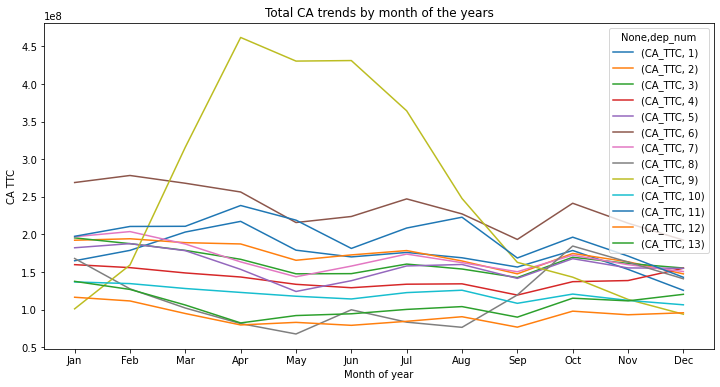

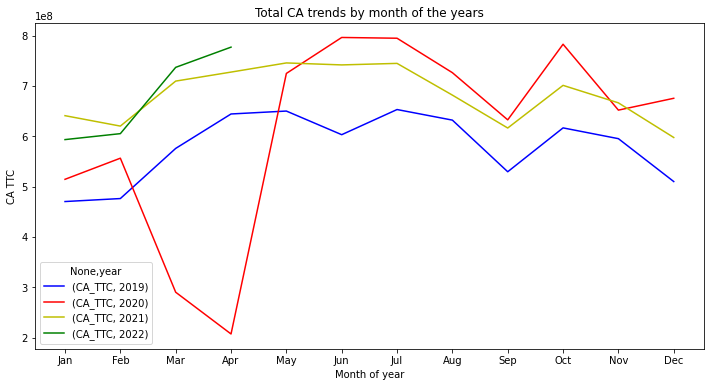

In [5]:
data['Month_of_year'] = data.calendar_date.apply(lambda x: x.month_name())
data['year'] = data.calendar_date.dt.year
cats = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

data.groupby(['Month_of_year', 'dep_num']).agg({'CA_TTC':'sum'}).unstack().reindex(cats).plot(figsize=(12,6))

ticks = list(range(0, 12, 1)) # points on the x axis where you want the label to appear
labels = "Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split()
plt.xticks(ticks, labels)
plt.title("Total CA trends by month of the years")
plt.xlabel('Month of year')
plt.ylabel('CA TTC')
plt.show()

data.groupby(['Month_of_year', 'year']).agg({'CA_TTC':'sum'}).unstack().reindex(cats).plot(figsize=(12,6), color=['b', 'r', 'y', 'g'], subplots=False)
ticks = list(range(0, 12, 1)) # points on the x axis where you want the label to appear
labels = "Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split()
plt.xticks(ticks, labels)
plt.title("Total CA trends by month of the years")
plt.xlabel('Month of year')
plt.ylabel('CA TTC')
plt.show()

## Observations
- rayon 9 different behavior (March to September).
- odd behavior in 2020 (could it be Corona? )



## Makeing the models

In [11]:
# specifying the supplier that we want to predict its Sales (CA)
sup_num = 4646

In [12]:
# preparing the data
# we use one month as test (cut_date)
current_date = data.calendar_date.max() + MonthEnd(0)
cut_date = pd.to_datetime((current_date - pd.Timedelta(days=63)), format="%Y%m") + MonthEnd(0)

# grouping the sales (CA_TTC) daily -> we observed that some suppliers are reported 2 or more times in a day
# also, we observed that the dep can be different! (example: sup = 7982, date=2022-04-22 ==> dep_num = 9 and 4!)
data_fb = data[data['supplier_number'] == sup_num]
data_fb = data_fb.groupby(['supplier_number', 'calendar_date'], as_index=False).agg({'CA_TTC':'sum', 'MSV':'sum', 'boni':'sum', 'CME':'sum', 'CMI':'sum', 'RFA':'sum', 'year':'max'})

In [13]:
# create train and test
train_prophet = data_fb[(data_fb.calendar_date <= cut_date) & (data_fb.year >= 2019)].copy()

test_prophet = data_fb[(data_fb.calendar_date > cut_date)].copy()
len_real_data_4test = len(test_prophet)

test_prophet_tmp = pd.DataFrame({'calendar_date':pd.date_range(data_fb.calendar_date.max(), periods=12, freq='m'), 'CA_TTC':0})
test_prophet_tmp.calendar_date = test_prophet_tmp.calendar_date + pd.Timedelta(days=1)
test_prophet = test_prophet.append(test_prophet_tmp, ignore_index=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_18144\638669702.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prophet = test_prophet.append(test_prophet_tmp, ignore_index=True)

  test_prophet = test_prophet.append(test_prophet_tmp, ignore_index=True)



In [14]:
# Create the model
model_prophet = Prophet(yearly_seasonality=True)

# fit train data to the model
model_prophet.fit(train_prophet.rename(columns={'calendar_date':'ds', 'CA_TTC':'y'}))

# Predict on training set with model
prediction_prophet = model_prophet.predict(df=test_prophet.reset_index().rename(columns={'calendar_date':'ds'}))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\Anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\Anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\Anaconda3\envs\time_series\lib\si

In [15]:
# also create model for Neural Prophet
data_train_np = train_prophet[['calendar_date', 'CA_TTC']].rename(columns={'calendar_date':'ds', 'CA_TTC':'y'})
data_test_np = test_prophet[['calendar_date', 'CA_TTC']].rename(columns={'calendar_date':'ds', 'CA_TTC':'y'})

model_nprophet = NeuralProphet()

metrics = model_nprophet.fit(data_train_np, freq="D")

prediction_nprophet = model_nprophet.predict(data_test_np)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 89.474% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 89.474% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epo

  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-01, min: 2.76E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.23E-01, min: 2.76E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.44E-02, min: 1.50E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.44E-02, min: 1.50E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.16E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 8.16E-02
Epoch[1000/1000]: 100%|█| 1000/1000 [00:07<00:00, 136.96it/s, SmoothL1Loss=0.0108, MAE=1.3e+6, RMSE=1.79e+6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 85.714% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 85.714% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency MS


In [16]:
# compute MAE and MSE for the predicted months

# total predicted CA for the month
ca_m_p = prediction_prophet.yhat[:len_real_data_4test]
ca_m_np = prediction_nprophet.yhat1[:len_real_data_4test]

# print("predicted CA:", ca_m_p)

# total actual CA for the month
ca_m_a = test_prophet.CA_TTC[:len_real_data_4test]
# print("Actual CA:", ca_m_a)

# evaluate forecasts
mae = mean_absolute_error(ca_m_p, ca_m_a)
mae_n = mean_absolute_error(ca_m_np, ca_m_a)
print('Test MAE Prohpet: %.3f' % mae)
print('Test MAE Neural Prohpet: %.3f' % mae_n)

mse = mean_squared_error(ca_m_p, ca_m_a)
mse_n = mean_squared_error(ca_m_np, ca_m_a)
print('Test MSE Prohpet: %.3f' % mse)
print('Test MSE Neural Prohpet: %.3f' % mse_n)

rmse = mean_squared_error(ca_m_p, ca_m_a, squared=False)
rmse_n = mean_squared_error(ca_m_np, ca_m_a, squared=False)
print('Test RMSE Prophet: %.3f' % rmse)
print('Test RMSE Neural Prophet: %.3f' % rmse_n)

Test MAE Prohpet: 1571789.066
Test MAE Neural Prohpet: 1383199.625
Test MSE Prohpet: 3545227961205.104
Test MSE Neural Prohpet: 2452040663616.597
Test RMSE Prophet: 1882877.575
Test RMSE Neural Prophet: 1565899.315


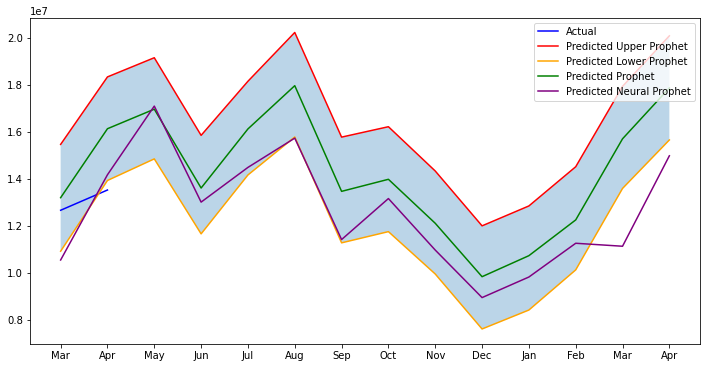

In [17]:
# plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(test_prophet.CA_TTC[:len_real_data_4test], color='b', label="Actual")
plt.plot(prediction_prophet.yhat_upper, color='red', label="Predicted Upper Prophet")
plt.plot(prediction_prophet.yhat_lower, color='orange', label="Predicted Lower Prophet")
plt.plot(prediction_prophet.yhat, color='green', label="Predicted Prophet")
plt.plot(prediction_nprophet.yhat1, color='purple', label="Predicted Neural Prophet")
plt.fill_between(range(len(test_prophet)), prediction_prophet.yhat_upper, prediction_prophet.yhat_lower, alpha=0.3)

m_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
labels = [m_names[i-1] for i in test_prophet.calendar_date.dt.month]
plt.xticks(range(len(test_prophet.calendar_date.dt.month)), labels)

plt.legend(loc="upper right")
plt.show()

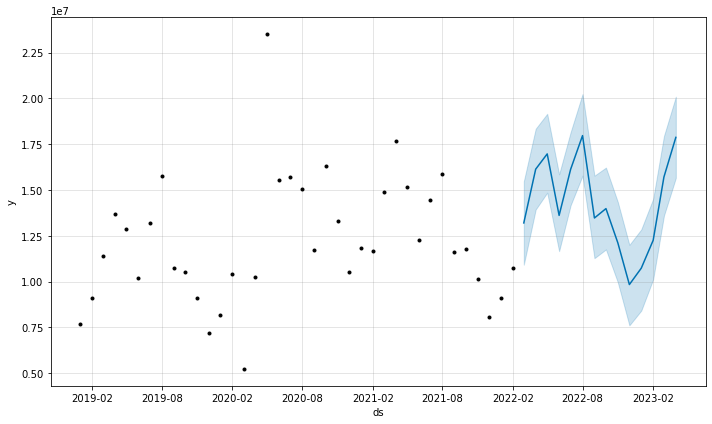

In [18]:
model_prophet.plot(prediction_prophet);

### CatBooast Model

In [14]:
new_df = data[data['supplier_number'] == sup_num]
new_df = new_df.groupby(['calendar_date'], as_index=False).agg({'CA_TTC':'sum'})
new_df['year'] = new_df.calendar_date.dt.year
new_df['Month_of_year'] = new_df['calendar_date'].dt.month

In [15]:
##### using previous data

# shift_period = 7 # amounts of previous data that we want to add as feature (n)
# data_tmp = series_to_supervised(new_df.CA_TTC.values, n_in=shift_period)
# new_df = new_df.iloc[shift_period:, :] # the first n rows have no previous data, so we delete them
# new_df = new_df.reset_index(drop=True)

# for i in range(1, data_tmp.shape[1]): # naming the columns of the new added features
#     col = 'CA_TTC' + str(i)
#     new_df[col] = data_tmp[:, i]

In [16]:
# create train and test
train_cb = new_df[(new_df.calendar_date <= cut_date) & (new_df.year >= 2019)].copy()
test_cb = new_df[(new_df.calendar_date > cut_date)].copy()
len_real_data_4test = len(test_cb)

train_cb_y = train_cb['CA_TTC']
train_cb = train_cb.drop('CA_TTC', 1)

test_cb_y = test_cb['CA_TTC'].reset_index(drop=True)
test_cb = test_cb.drop('CA_TTC', 1)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_10472\3303650748.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_cb = train_cb.drop('CA_TTC', 1)

  train_cb = train_cb.drop('CA_TTC', 1)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_10472\3303650748.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_cb = test_cb.drop('CA_TTC', 1)

  test_cb = test_cb.drop('CA_TTC', 1)



In [17]:
### test for one year
new_test_date = test_cb.calendar_date.max() + pd.Timedelta(days=1)
test_cb = new_df[(new_df.calendar_date > cut_date)].copy()

test_cb_tmp = pd.DataFrame({'calendar_date':pd.date_range(new_test_date, periods=12, freq='m'), 'CA_TTC':0})
test_cb_tmp.calendar_date = test_cb_tmp.calendar_date + pd.Timedelta(days=1)
test_cb_tmp['year'] = test_cb_tmp.calendar_date.dt.year
test_cb_tmp['Month_of_year'] = test_cb_tmp['calendar_date'].dt.month
test_cb = test_cb.append(test_cb_tmp, ignore_index=True)

test_cb_y = test_cb['CA_TTC'].reset_index(drop=True)
test_cb = test_cb.drop('CA_TTC', 1)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_10472\3397545128.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_cb = test_cb.append(test_cb_tmp, ignore_index=True)

  test_cb = test_cb.append(test_cb_tmp, ignore_index=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_10472\3397545128.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_cb = test_cb.drop('CA_TTC', 1)

  test_cb = test_cb.drop('CA_TTC', 1)



In [18]:
# creating the model
model_cb = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, loss_function='RMSE')

# train the model
model_cb.fit(train_cb, train_cb_y, verbose=False)

# making the prediction
predictions_cb = model_cb.predict(test_cb)

In [19]:
# evaluate forecasts

# total predicted CA for the month
ca_m_p_cb = predictions_cb[:len_real_data_4test]
# print("predicted CA:", ca_m_p)

# total actual CA for the month
ca_m_a_cb = test_cb_y[:len_real_data_4test]
# print("Actual CA:", ca_m_a)

mae_cb = mean_absolute_error(ca_m_a_cb, ca_m_p_cb)
print('Test MAE CatBoost: %.3f' % mae_cb)

mse_cb = mean_squared_error(ca_m_a_cb, ca_m_p_cb)
print('Test MSE CatBoost: %.3f' % mse_cb)

rmse = mean_squared_error(ca_m_a_cb, ca_m_p_cb, squared=False)
print('Test RMSE CatBoost: %.3f' % rmse)

Test MAE CatBoost: 752341.691
Test MSE CatBoost: 581715592350.316
Test RMSE CatBoost: 762702.820


In [20]:
# Gradient boosted tree regressors w/ different quantile losses
model_cb_ranged = [CatBoostRegressor(loss_function='Quantile:alpha=0.5')]
model_cb_ranged[0].fit(train_cb, train_cb_y, verbose=False)
model_cb_ranged_pred = np.empty([10, len(test_cb_y)])
model_cb_ranged_pred[0, :] = np.array(model_cb_ranged[0].predict(test_cb))

itr = 1
for i in np.arange(0.1, 1, 0.1):
    print('Quantile:alpha=' + str(i) + ' --> Done')
    model_cb_ranged.append(CatBoostRegressor(loss_function='Quantile:alpha='+str(i)))
    model_cb_ranged[itr].fit(train_cb, train_cb_y, verbose=False)
    model_cb_ranged_pred[itr, :] = np.array(model_cb_ranged[itr].predict(test_cb))

    itr = itr + 1
    
# compute the upper and lower prediction bounds
upper = np.zeros(len(test_cb_y))
lower = np.zeros(len(test_cb_y))
for i in range(len(test_cb_y)):
    upper[i] = max(model_cb_ranged_pred[:, i])
    lower[i] = min(model_cb_ranged_pred[:, i])


Quantile:alpha=0.1 --> Done
Quantile:alpha=0.2 --> Done
Quantile:alpha=0.30000000000000004 --> Done
Quantile:alpha=0.4 --> Done
Quantile:alpha=0.5 --> Done
Quantile:alpha=0.6 --> Done
Quantile:alpha=0.7000000000000001 --> Done
Quantile:alpha=0.8 --> Done
Quantile:alpha=0.9 --> Done


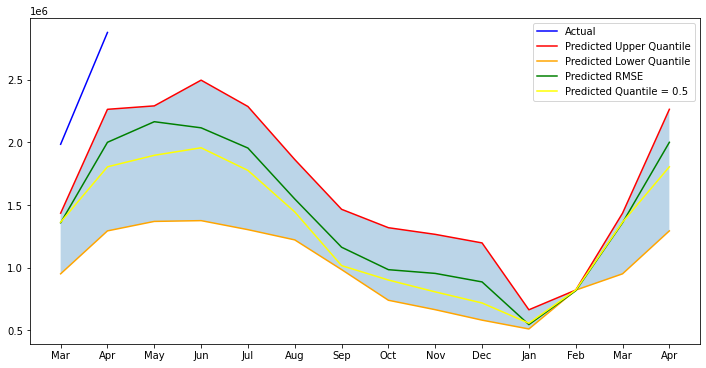

In [21]:
# plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(test_cb_y[:len_real_data_4test], color='b', label="Actual")
plt.plot(upper, color='red', label="Predicted Upper Quantile")
plt.plot(lower, color='orange', label="Predicted Lower Quantile")
plt.plot(predictions_cb, color='green', label="Predicted RMSE")
plt.plot(model_cb_ranged_pred[0], color='yellow', label="Predicted Quantile = 0.5")
plt.fill_between(range(len(test_cb_y)), upper, lower, alpha=0.3)

m_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
labels = [m_names[i-1] for i in test_cb.Month_of_year]
plt.xticks(range(len(test_cb)), labels)

plt.legend(loc="upper right")
plt.show()

# Plot all methods

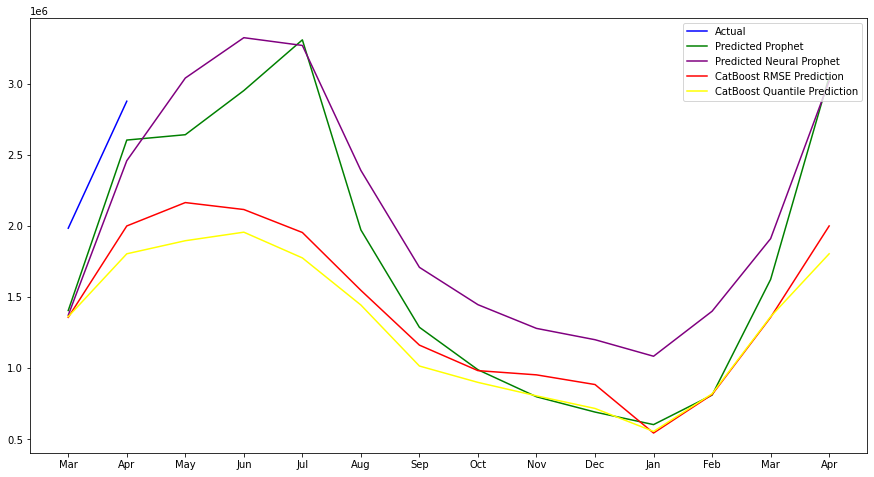

In [22]:
# plot forecasts against actual outcomes
plt.figure(figsize=(15, 8))

plt.plot(test_prophet.CA_TTC[:len_real_data_4test], color='b', label="Actual")
# plt.plot(prediction_prophet.yhat_upper, color='red', label="Predicted Upper Prophet")
# plt.plot(prediction_prophet.yhat_lower, color='orange', label="Predicted Lower Prophet")
plt.plot(prediction_prophet.yhat, color='green', label="Predicted Prophet")
plt.plot(prediction_nprophet.yhat1, color='purple', label="Predicted Neural Prophet")
# plt.fill_between(range(len(test_prophet)), prediction_prophet.yhat_upper, prediction_prophet.yhat_lower, alpha=0.3)


# plt.plot(upper, color='red', label="Predicted Upper Quantile")
# plt.plot(lower, color='orange', label="Predicted Lower Quantile")
plt.plot(predictions_cb, color='red', label="CatBoost RMSE Prediction")
plt.plot(model_cb_ranged_pred[0], color='yellow', label="CatBoost Quantile Prediction")
# plt.fill_between(range(len(test_cb_y)), upper, lower, alpha=0.3)

m_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
labels = [m_names[i-1] for i in test_cb.Month_of_year]
plt.xticks(range(len(test_cb)), labels)

plt.legend(loc="upper right")
plt.show()


# Cumulative view monthly

In [25]:
# cumulative view base on prophet algorithm
# prediction_prophet
train_max_year = train_prophet.calendar_date.max().year
train_max_month = train_prophet.calendar_date.max().month

data_com_yhat = data_fb[data_fb.calendar_date.dt.year >= train_max_year].reset_index(drop=True)
data_com_yhat = data_com_yhat[['supplier_number', 'calendar_date', 'CA_TTC']]

df_tmp = prediction_prophet[['ds', 'yhat']]
df_tmp.columns = ['calendar_date', 'CA_TTC']
df_tmp['supplier_number'] = sup_num
df_tmp = df_tmp[(df_tmp.calendar_date > data_com_yhat.calendar_date.max()) & (df_tmp.calendar_date.dt.year <= train_max_year)]

data_com_yhat = data_com_yhat.append(df_tmp).reset_index(drop=True)


############# compute for lower and upper case now
### lower
data_com_yhat_lower = data_fb[data_fb.calendar_date.dt.year >= train_max_year].reset_index(drop=True)
data_com_yhat_lower = data_com_yhat_lower[['supplier_number', 'calendar_date', 'CA_TTC']]

df_tmp = prediction_prophet[['ds', 'yhat_lower']]
df_tmp.columns = ['calendar_date', 'CA_TTC']
df_tmp['supplier_number'] = sup_num
df_tmp = df_tmp[(df_tmp.calendar_date > data_com_yhat_lower.calendar_date.max()) & (df_tmp.calendar_date.dt.year <= train_max_year)]

data_com_yhat_lower = data_com_yhat_lower.append(df_tmp).reset_index(drop=True)

### Upper
data_com_yhat_upper = data_fb[data_fb.calendar_date.dt.year >= train_max_year].reset_index(drop=True)
data_com_yhat_upper = data_com_yhat_upper[['supplier_number', 'calendar_date', 'CA_TTC']]

df_tmp = prediction_prophet[['ds', 'yhat_upper']]
df_tmp.columns = ['calendar_date', 'CA_TTC']
df_tmp['supplier_number'] = sup_num
df_tmp = df_tmp[(df_tmp.calendar_date > data_com_yhat_upper.calendar_date.max()) & (df_tmp.calendar_date.dt.year <= train_max_year)]

data_com_yhat_upper = data_com_yhat_upper.append(df_tmp).reset_index(drop=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_10472\3632381109.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['supplier_number'] = sup_num

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['supplier_number'] = sup_num

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_10472\3632381109.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_com_yhat = 

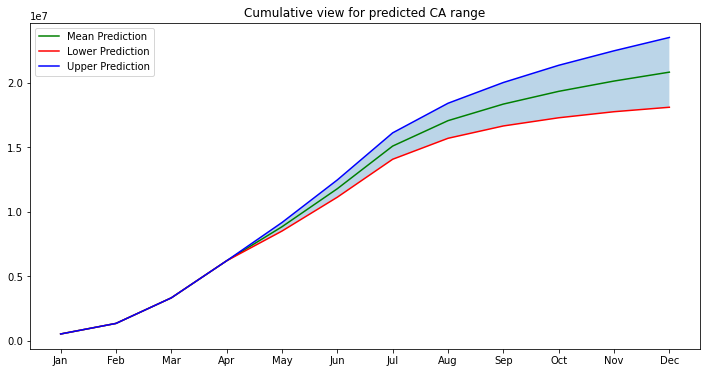

In [26]:
lower_plt = np.cumsum(data_com_yhat_lower.CA_TTC)
mean_plt = np.cumsum(data_com_yhat.CA_TTC)
upper_plt = np.cumsum(data_com_yhat_upper.CA_TTC)


plt.figure(figsize=(12, 6))

plt.plot(mean_plt, label = 'Mean Prediction', color='g')
plt.plot(lower_plt, label = 'Lower Prediction', color='r')
plt.plot(upper_plt, label = 'Upper Prediction', color='b')
plt.fill_between(range(len(lower_plt)), lower_plt, upper_plt, alpha=0.3)

labels = "Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split()
ticks = list(range(0, 12, 1))
plt.xticks(ticks, labels)
plt.legend(loc="upper left")
plt.title('Cumulative view for predicted CA range')
plt.show()